In [2]:
import pandas as pd 
import numpy as np

import os
import glob 

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt

import seaborn as sns

from scipy.interpolate import interp2d

In [7]:
## Importing data
df_prodHist = pd.read_csv("production_history.csv")

df_preProc = pd.read_csv("wellbore_data_preproduction_well.csv")
df_producer = pd.read_csv("wellbore_data_producer_wells.csv")      #This is the training data

#Horizon/Formation data 
AI = np.load("2d_ai.npy")
sandFraction = np.load("2d_sand_propotion.npy")
sandyShaleFraction = np.load("2d_sandy_shale_propotion.npy")
shaleFraction = np.load("2d_shale_propotion.npy")
shalySandFraction = np.load("2d_shaly_sand_propotion.npy")
topDepth = np.load("2d_top_depth.npy")

#Merge data of two tables 
df_producer_hist = df_producer.merge(df_prodHist, how = 'inner', on = 'Well_ID')

## Figure of all horizon slices 

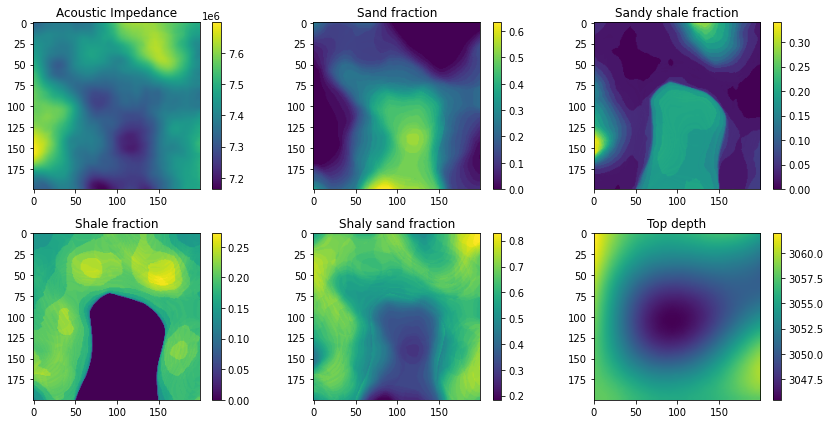

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))
im1 = ax[0, 0].imshow(AI)
ax[0, 0].set_title('Acoustic Impedance')
fig.colorbar(im1, ax = ax[0, 0])

im2 = ax[0, 1].imshow(sandFraction)
ax[0, 1].set_title('Sand fraction')
fig.colorbar(im2, ax = ax[0, 1])

im3 = ax[0, 2].imshow(sandyShaleFraction)
ax[0, 2].set_title('Sandy shale fraction')
fig.colorbar(im3, ax = ax[0, 2])

im4 = ax[1, 0].imshow(shaleFraction)
ax[1, 0].set_title('Shale fraction')
fig.colorbar(im4, ax = ax[1, 0])

im5 = ax[1, 1].imshow(shalySandFraction)
ax[1, 1].set_title('Shaly sand fraction')
fig.colorbar(im5, ax = ax[1, 1])

im6 = ax[1, 2].imshow(topDepth)
ax[1, 2].set_title('Top depth')
fig.colorbar(im6, ax = ax[1, 2])

plt.tight_layout()

## Figure of well number and well location

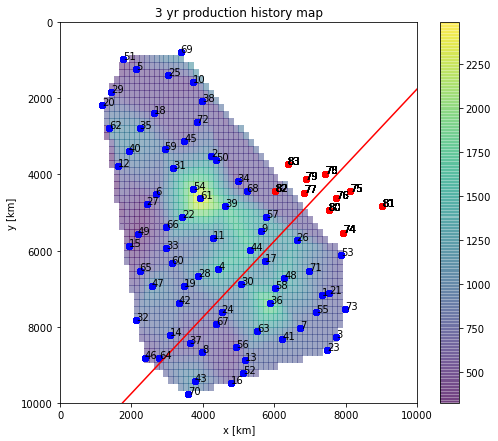

In [27]:
## Plotting 3yr production-map with Well number 
df = df_producer_hist
df = df.groupby('Well_ID').agg('mean').reset_index()
df_ML = df.merge(df_prodHist, how = 'inner', on = 'Well_ID')

wellNumberMarker = [x.split("_")[-1] for x in df_ML['Well_ID'].values]
wellNumberMarker_targetWell = [x.split("_")[-1] for x in df_preProc['Well_ID'].values]

fig, ax = plt.subplots(figsize = (8, 7))
im = ax.pcolormesh(X, Y, Z, shading='auto', alpha = 0.5) 
ax.plot([10000, 1750], [1750, 10000], 'r')
ax.scatter(df_producer['X, m'], df_producer['Y, m'], c = 'blue')
ax.scatter(df_preProc['X, m'], df_preProc['Y, m'], c = 'red')

#back group data plot
for i, txt in enumerate(wellNumberMarker):
    ax.annotate(txt, ((df_ML['X, m'][i], df_ML['Y, m'][i])))
for i, txt in enumerate(wellNumberMarker_targetWell):
    ax.annotate(txt, ((df_preProc['X, m'][i], df_preProc['Y, m'][i])))
    
ax.set_xlim([0, 10000])
ax.set_ylim([0, 10000])
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('3 yr production history map')

fig.colorbar(im, ax=ax)
plt.gca().invert_yaxis()

## Plotting well data 

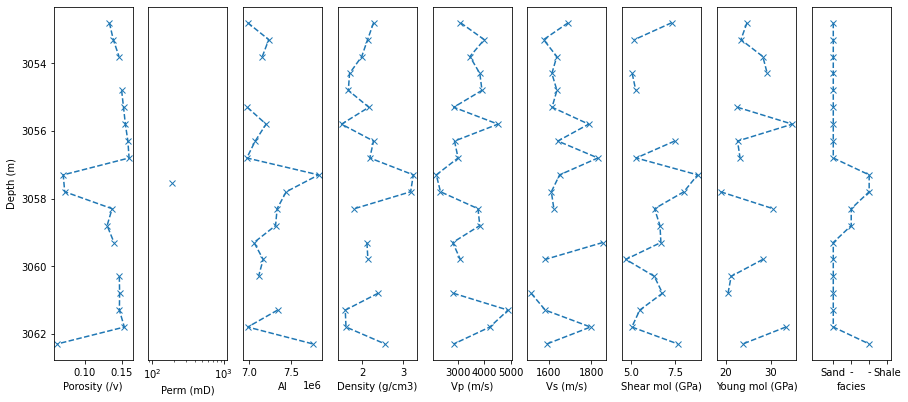

In [29]:
def plotData(df, wellNum = 1):
    df_filt = df[df['Well_ID'] == "Well_no_{}".format(wellNum)]
    
    depth = df_filt['Depth, m']
    
    ##Plotting part
    fig, ax = plt.subplots(nrows = 1, ncols = 9, figsize = (15, 6.5))
    
    ax[0].plot(df_filt['Porosity, fraction'], depth, 'x--')
    ax[0].set_xlabel('Porosity (/v)')
    ax[0].set_ylabel('Depth (m)')
    ax[0].invert_yaxis()
 
    ax[1].plot(df_filt['Permeability, mD'], depth, 'x')
    ax[1].set_xlabel('Perm (mD)')
    ax[1].set_xscale('log')
    ax[1].invert_yaxis()
    ax[1].get_yaxis().set_ticks([])
    
    ax[2].plot(df_filt['Acoustic Impedance, kg*s/m^2'], depth, 'x--')
    ax[2].set_xlabel('AI')
    ax[2].invert_yaxis()
    ax[2].get_yaxis().set_ticks([])

    ax[3].plot(df_filt['Density, g/cm3'], depth, 'x--')
    ax[3].set_xlabel('Density (g/cm3)')
    ax[3].invert_yaxis()
    ax[3].get_yaxis().set_ticks([])
 
    ax[4].plot(df_filt['Compressible velocity, m/s'], depth, 'x--')
    ax[4].set_xlabel('Vp (m/s)')
    ax[4].invert_yaxis()
    ax[4].get_yaxis().set_ticks([])

    ax[5].plot(df_filt['Shear velocity, m/s'], depth, 'x--')
    ax[5].set_xlabel('Vs (m/s)')
    ax[5].invert_yaxis()
    ax[5].get_yaxis().set_ticks([])

    ax[6].plot(df_filt['Shear modulus, GPa'], depth, 'x--')
    ax[6].set_xlabel('Shear mol (GPa)')
    ax[6].invert_yaxis()
    ax[6].get_yaxis().set_ticks([])

    ax[7].plot(df_filt['Youngs modulus, GPa'], depth, 'x--')
    ax[7].set_xlabel('Young mol (GPa)')
    ax[7].invert_yaxis()
    ax[7].get_yaxis().set_ticks([])
    
    faciesDict = {'Sandstone': 1, 'Sandy shale': 3, 'Shaly sandstone': 2, 'Shale': 4, np.nan: np.nan}
    facieLable = [faciesDict[x] for x in df_filt['Rock facies'].values]
    ax[8].plot(facieLable, depth, 'x--')
    ax[8].set_xlabel('facies')
    ax[8].invert_yaxis()
    ax[8].get_yaxis().set_ticks([])
    ax[8].set_xticks([1,2,3,4])
    ax[8].set_xticklabels(['Sand', '-', '-', 'Shale'])
    ax[8].set_xlim([-0.2, 4.2])
    
plotData(df = df_producer, wellNum = 1)

## Plotting the well data of the k-nearest well 

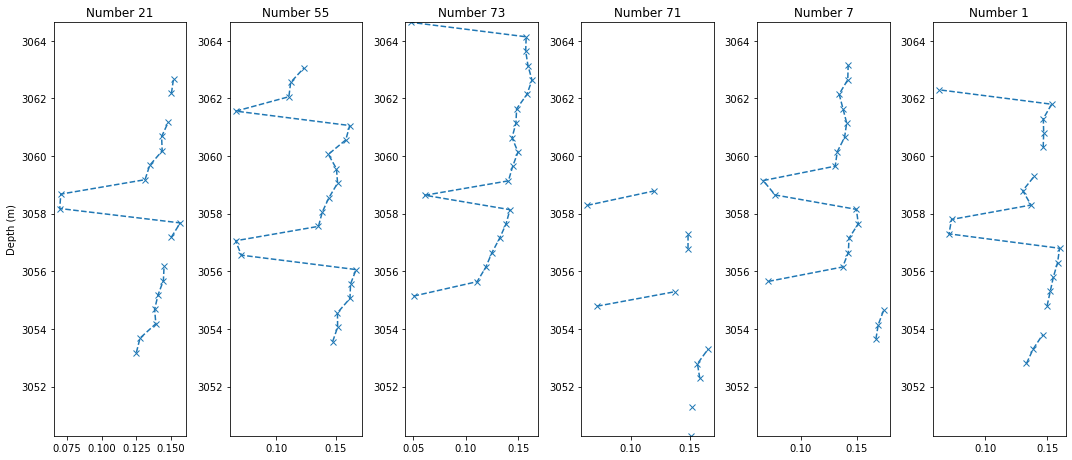

In [31]:
def kNearestWell(df = df_producer, centerWellNumber = 1, k = 5):
    df = df_producer.groupby('Well_ID').agg('mean').reset_index()

    targetWell_X = df[df['Well_ID'] == "Well_no_{}".format(centerWellNumber)]["X, m"]
    targetWell_Y = df[df['Well_ID'] == "Well_no_{}".format(centerWellNumber)]["Y, m"]

    df['distance'] = np.sqrt( (targetWell_X.values - df['X, m'].values)**2 + (targetWell_Y.values - df['Y, m'].values)**2)

    df_sorted = df.sort_values(by = ['distance'], inplace = False)

    return [int(x.split("_")[-1]) for x in df_sorted.iloc[1:(k+1), :]['Well_ID'].values]

def plotLog(df = df_producer, targetLogName = 'Porosity, fraction', centerWellNumber = 1, nearestWellNumber = [21, 55, 73, 71, 7], topRes = topDepth, dx = 50, dy = 50):
    #Note --> topRes --> 2D numpy array of the reservoir depth (horizon!!)
    #dx and dy is the cell spacing of the "topRes" orizon
    
    #adding centerwell as the last item 
    nearestWellNumber.append(centerWellNumber)
    
    fig, ax = plt.subplots(nrows = 1, ncols = len(nearestWellNumber), figsize = (15, 6.5))
    
    minDepth = 1e9
    maxDepth = 0
    
    for wellPlot, plotNum in zip(nearestWellNumber, range(len(nearestWellNumber))):
        df_filt = df[df['Well_ID'] == "Well_no_{}".format(wellPlot)]
        depth = df_filt['Depth, m'] 
        
        if np.min(depth.values) < minDepth:
            minDepth = np.min(depth.values)
        if np.max(depth.values) > maxDepth:
            maxDepth = np.max(depth.values)   
        ax[plotNum].plot(df_filt['Porosity, fraction'], depth, 'x--')
        if plotNum == 0:
            ax[plotNum].set_ylabel('Depth (m)')

        ax[plotNum].invert_yaxis()
        
        for i in range(len(nearestWellNumber)):
            ax[i].set_ylim([minDepth, maxDepth])
        
        plt.tight_layout()
        
        ax[plotNum].set_title('Number {}'.format(wellPlot))
        
        #2D Interpolation of the well location  
        """
        X = np.arange(0, topRes.shape[1], dx)
        Y = np.arange(0, topRes.shape[0], dy)
        X, Y = np.meshgrid(X, Y) 
        zDepth = interp2d(X, Y, topRes, kind='linear')   #this gives you function NOT THE DEPTH 
        
        reservoirDepth = zDepth[df_filt['X, m'], df_filt['Y, m']]
        """
        
x = kNearestWell(df = df_producer, centerWellNumber = 1, k = 5)
plotLog(df = df_producer, targetLogName = 'Porosity, fraction', centerWellNumber = 1, nearestWellNumber = x, topRes = topDepth, dx = 50, dy = 50)